# Can we both flip and not flip in a single model?

So, this Notebook explores the possible solutions to our left/right hand weakness of our static model.

## First part deals with flipped/not flipped images

This is a little cursed, flipped simply means we ran cv.flip(img, 1), to horizontally flip the image before giving it to MediaPipe

##### Every letters gets an extra class for flipped/not flipped

First part will make it so:

That is every class (letter from alphabet) there will be a flipped and not.


So for the letter B:
- B_flip and
- B_notflip

In [28]:
from sign.training.load_data.StaticLandmarkLoader import StaticLandmarkLoader, TrainingData
from pathlib import Path
from sklearn.model_selection import train_test_split

BACKEND_MODEL = Path().cwd().parent.joinpath("backend","model")
NOT_FLIPPED = BACKEND_MODEL.joinpath("NOT_FLIPPED_keypoints_from_data.csv")
FLIPPED = BACKEND_MODEL.joinpath("FLIPPED_keypoints_from_data.csv")

loader = StaticLandmarkLoader()
nf = loader.load_training_data(str(NOT_FLIPPED.absolute()))
yf = loader.load_training_data(str(FLIPPED.absolute()))

def add_flipped(list, is_flipped: bool):
    """Adds the flipped name onto the label of the data"""
    return map(lambda label: label + ("_1" if is_flipped else "_0"), list)

def concat(*lists):
    res = []
    for l in lists:
        res = res + list(l)
    return res

def train_test_split_concat(data, labels):
    zipped = list(zip(data, labels))
    train_set, test_set = train_test_split(zipped, test_size=0.2, random_state=42)

    lnds_train, labels_train = list(zip(*train_set))
    lnds_test, labels_test = list(zip(*test_set))
    return lnds_train, labels_train, lnds_test, labels_test

#Prepare training (and test data) that have had their flipped status added to their label
combined_landmarks = concat(nf.landmarks_train,
                            nf.landmarks_test,
                            yf.landmarks_train,
                            yf.landmarks_test)
combined_labels = concat(add_flipped(nf.labels_train, False), 
                         add_flipped(nf.labels_test, False), 
                         add_flipped(yf.labels_train, True), 
                         add_flipped(yf.labels_test, True))

lnds_train, labels_train, lnds_test, labels_test = train_test_split_concat(combined_landmarks, combined_labels)
len(lnds_train), len(lnds_test)

(95532, 23884)

In [29]:
#Build the classifier - naive approach with every letter getting a left/right class
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

classifier = make_pipeline(StandardScaler(),
                           SVC(kernel="poly", degree=3, coef0=1, C=1))
classifier.fit(lnds_train, labels_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, coef0=1, kernel='poly'))])

In [30]:
from sklearn.metrics import classification_report


predictions = classifier.predict(lnds_test)
print(classification_report(labels_test, predictions))

              precision    recall  f1-score   support

         A_0       0.99      0.99      0.99       394
         A_1       1.00      1.00      1.00       403
         B_0       0.99      1.00      1.00       466
         B_1       0.98      1.00      0.99       384
         C_0       0.99      1.00      1.00       368
         C_1       1.00      1.00      1.00       370
         D_0       1.00      1.00      1.00       445
         D_1       1.00      1.00      1.00       463
         E_0       1.00      0.99      0.99       478
         E_1       1.00      1.00      1.00       430
         F_0       0.99      0.99      0.99       573
         F_1       1.00      1.00      1.00       540
         G_0       1.00      1.00      1.00       511
         G_1       1.00      1.00      1.00       454
         H_0       1.00      1.00      1.00       433
         H_1       1.00      1.00      1.00       476
         I_0       0.99      1.00      0.99       445
         I_1       1.00    

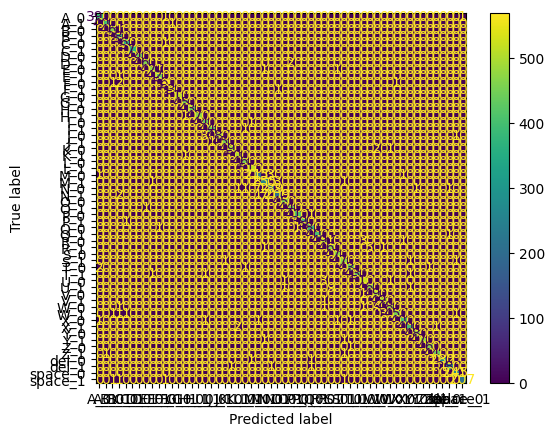

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

#predictions = classifier.predict(lnds_test)
ConfusionMatrixDisplay.from_predictions(labels_test, predictions)
plt.show()

##### Instead of a separate class, we insert an extra feature to mark left / right

So, at the end of a "sign", that is after the last landmark (42th value, that is the last z of the 21st landmark) insert either a 1 (flipped) or 0 (not flipped)

In [32]:
import numpy as np
# Let's try to append an 0 or 1 to the train_data
    # insert a 0 or 1 after each 42th float to mark wether it is flipped or not
def insert_at_nth(arr:np.ndarray, N:int, insert:float):
    arr2 = arr.flatten()
    return np.append(np.insert(arr2, range(N, len(arr2), N), insert), 0).reshape((-1, N + 1))

N = 42
combined_landmarks = concat(insert_at_nth(nf.landmarks_train, N, 0),
                            insert_at_nth(nf.landmarks_test, N, 0),
                            insert_at_nth(yf.landmarks_train, N, 1),
                            insert_at_nth(yf.landmarks_test, N,1))
combined_labels = concat(nf.labels_train,
                         nf.labels_test, 
                         yf.labels_train,
                         yf.labels_test)
lnds_train, labels_train, lnds_test, labels_test = train_test_split_concat(combined_landmarks, combined_labels)


In [33]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

classifier_extra_feature = make_pipeline(StandardScaler(),
                                         SVC(kernel="poly", degree=3, coef0=1, C=1))
classifier_extra_feature.fit(lnds_train, labels_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, coef0=1, kernel='poly'))])

In [34]:
from sklearn.metrics import classification_report


predictions = classifier_extra_feature.predict(lnds_test)
print(classification_report(labels_test, predictions))

              precision    recall  f1-score   support

           A       0.99      1.00      1.00       797
           B       0.99      1.00      0.99       850
           C       1.00      1.00      1.00       738
           D       1.00      1.00      1.00       908
           E       1.00      1.00      1.00       908
           F       1.00      1.00      1.00      1113
           G       1.00      1.00      1.00       965
           H       1.00      1.00      1.00       909
           I       0.99      1.00      0.99       888
           J       1.00      0.99      1.00       949
           K       1.00      1.00      1.00       999
           L       1.00      1.00      1.00       976
           M       0.97      0.98      0.97       489
           N       0.98      0.95      0.97       424
           O       0.99      1.00      1.00       908
           P       1.00      1.00      1.00       818
           Q       1.00      1.00      1.00       790
           R       0.98    

**Now test the two different approaches against our homemade data for 'U'**

First, read in the data from csv

In [35]:
lnds_stest, labels_stest = loader.load_test_data("bing_bong.csv")
labels_stest_with_feature = list(map(lambda x: x.split("_")[0], labels_stest))

lnds_stest2:np.ndarray = lnds_stest
for idx, label in enumerate(labels_stest):
    l, hand = label.split("_")
    idex = (idx+1) * 42
    if hand.capitalize() == "LEFT":
        lnds_stest2 = np.insert(lnds_stest2, idex, 0)
    else:
        lnds_stest2 = np.insert(lnds_stest2, idex, 1)
#print(lnds_stest2.reshape((-1, 43)))
lnds_stest2 = lnds_stest2.reshape((-1,43))

#lnds_stest_with_feature = insert_at_nth(np.array(lnds_stest), N, 1)

In [36]:
# Let's investigate the one with an extra feature:
predictions_U_left_right = classifier_extra_feature.predict(lnds_stest2)
print(classification_report(labels_stest_with_feature, predictions_U_left_right))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         0
           B       0.00      0.00      0.00         0
           C       0.00      0.00      0.00         0
           D       0.00      0.00      0.00         0
           E       0.00      0.00      0.00         0
           F       0.00      0.00      0.00         0
           G       0.00      0.00      0.00         0
           H       0.00      0.00      0.00         0
           I       0.00      0.00      0.00         0
           J       0.00      0.00      0.00         0
           K       0.00      0.00      0.00         0
           L       0.00      0.00      0.00         0
           M       0.00      0.00      0.00         0
           N       0.00      0.00      0.00         0
           O       0.00      0.00      0.00         0
           P       0.00      0.00      0.00         0
           Q       0.00      0.00      0.00         0
           R       0.00    

/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

In [37]:
# Let's invistage the model where (not) flipped get different classes
def mapper(x:str):
    label, hand = x.split("_")
    return label + ("_1" if hand == "RIGHT" else "_0")

labels_extra_classes = list(map(mapper, labels_stest))
predictions_U_left_right = classifier.predict(lnds_stest)
print(classification_report(labels_extra_classes, predictions_U_left_right))

              precision    recall  f1-score   support

         C_1       0.00      0.00      0.00         0
         D_1       0.00      0.00      0.00         0
         H_0       0.00      0.00      0.00         0
         H_1       0.00      0.00      0.00         0
         I_0       0.00      0.00      0.00         0
         I_1       0.00      0.00      0.00         0
         K_0       0.00      0.00      0.00         0
         L_0       0.00      0.00      0.00         0
         N_0       0.00      0.00      0.00         0
         P_0       0.00      0.00      0.00         0
         P_1       0.00      0.00      0.00         0
         Q_0       0.00      0.00      0.00         0
         R_0       0.00      0.00      0.00         0
         R_1       0.00      0.00      0.00         0
         U_0       1.00      0.10      0.17       714
         U_1       1.00      0.08      0.15       460
         V_0       0.00      0.00      0.00         0
         V_1       0.00    

/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

## What if we instead use right/left from mp?

Okay, so for this scenario we will append to our ouput csv (output from mediapipe), the handedness that MediaPipe provides.
Meaning, every "sign" in our training data will be marked as either having been done by a "right" or "left" hand.


The first model using right/left from MediaPipe will use the extra feature approach. (I believe that one had the best results from the earlier flipped/not-flipped testing)

In [38]:
from sign.training.load_data.StaticLandmarkLoader import StaticLandmarkLoader
import numpy as np
loader = StaticLandmarkLoader()
td = loader.load_handed_training_data(file_path="../backend/model/handedness_keypoints_from_data.csv")
x_train, y_train, x_test, y_test, h_train, h_test = td

if h_train is None or h_test is None:
    raise ValueError(f"Something is empty that shouldn't be")

def append_handedness(xs:np.ndarray, hands:np.ndarray):
    res = []
    for i in range(len(xs)):
        res.append(np.append(xs[i], 1 if hands[i] == "right" else 0))
    return np.array(res).reshape((-1,43))

x_train = append_handedness(x_train, h_train)
x_test = append_handedness(x_test, h_test)
    

In [39]:
#Train a model on it.
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

classifier_rl = make_pipeline(StandardScaler(),
                              SVC(kernel="poly", degree=3, coef0=1, C=1))
classifier_rl.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, coef0=1, kernel='poly'))])

In [40]:
from sklearn.metrics import classification_report
preds = classifier_rl.predict(x_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           A       0.99      1.00      1.00       821
           B       0.99      1.00      0.99       875
           C       0.99      1.00      0.99       743
           D       1.00      0.99      1.00       936
           E       0.99      1.00      1.00       882
           F       1.00      1.00      1.00      1116
           G       1.00      1.00      1.00       930
           H       1.00      1.00      1.00       851
           I       0.99      1.00      0.99       884
           J       1.00      0.99      0.99       971
           K       1.00      0.99      1.00      1039
           L       1.00      1.00      1.00       955
           M       0.95      0.98      0.97       459
           N       0.99      0.94      0.96       402
           O       0.99      1.00      1.00       862
           P       1.00      0.99      0.99       780
           Q       0.99      1.00      0.99       808
           R       0.98    

/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

In [41]:
def filter_stest(lnds_stest, labels_stest, hand:str = ""):
    zipped = zip(lnds_stest, labels_stest)
    if hand:
        return zip(*list(filter(lambda x: x[1].split("_")[1] == hand,zipped)))
    else:
        return zip(*zipped)

In [42]:
lnds_stest, labels_stest = loader.load_test_data("bing_bong.csv")
lnds_stest, labels_stest = filter_stest(lnds_stest, labels_stest, "")
stest_handed = np.array(list(map(lambda x: x.split("_")[1].lower(),labels_stest)))
#stest_handed = np.array(list(map(lambda x: "left" if x.lower() == "right" else "right", stest_handed)))
lnds_stest = append_handedness(np.array(lnds_stest), stest_handed)
labels_stest = list(map(lambda x: x[0], labels_stest))

In [43]:
stest_preds = classifier_rl.predict(lnds_stest)
cr = classification_report(labels_stest, stest_preds)
print(cr)

              precision    recall  f1-score   support

           C       0.00      0.00      0.00         0
           D       0.00      0.00      0.00         0
           G       0.00      0.00      0.00         0
           H       0.00      0.00      0.00         0
           I       0.00      0.00      0.00         0
           L       0.00      0.00      0.00         0
           N       0.00      0.00      0.00         0
           P       0.00      0.00      0.00         0
           Q       0.00      0.00      0.00         0
           R       0.00      0.00      0.00         0
           S       0.00      0.00      0.00         0
           U       1.00      0.03      0.05      1174
           V       0.00      0.00      0.00         0
           W       0.00      0.00      0.00         0
           X       0.00      0.00      0.00         0
           Z       0.00      0.00      0.00         0
         del       0.00      0.00      0.00         0

    accuracy              

/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

### What if model is only left or right handed

Meaning, create two models: 
1. That understands signs done with a "left" hand
2. And another that understands signs done with a "right" hand

In [61]:
from sign.training.load_data.StaticLandmarkLoader import StaticLandmarkLoader
loader = StaticLandmarkLoader()
td = loader.load_handed_training_data(file_path="../backend/model/handedness_keypoints_from_data.csv")
x_train, y_train, x_test, y_test, h_train, h_test = td

def extract_hand_data(xs, ys, hs):
    zipped = list(zip(xs, ys, hs))
    lefts = list(filter(lambda x: x[2].lower() == "left", zipped))
    rights = list(filter(lambda x: x[2].lower() == "right", zipped))
    return zip(*lefts),zip(*rights)

lefts, rights = extract_hand_data(x_train, y_train, h_train)
x_l_train, y_l_train, x_l_hand = lefts
x_r_train, y_r_train, y_r_hand = rights

lefts_test, rights_test = extract_hand_data(x_test, y_test, h_test)
x_l_test, y_l_test, _ = lefts_test
x_r_test, y_r_test, _ = rights_test


In [45]:
#Train a model on it.
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

ceof0 = 250
degrees = 4
C = 0.25

cls_left = make_pipeline(StandardScaler(),
                             SVC(kernel="poly", degree=degrees, coef0=ceof0, C=C))
cls_left.fit(x_l_train, y_l_train)

cls_right = make_pipeline(StandardScaler(),
                              SVC(kernel="poly", degree=degrees, coef0=ceof0, C=C))
cls_right.fit(x_r_train, y_r_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.25, coef0=250, degree=4, kernel='poly'))])

In [46]:
## Classification report for left hand
from sklearn.metrics import classification_report
preds_left = cls_left.predict(x_l_test)
print(classification_report(y_l_test, preds_left))

              precision    recall  f1-score   support

           A       0.99      1.00      1.00       413
           B       0.99      1.00      1.00       453
           C       0.99      1.00      1.00       431
           D       0.99      1.00      1.00       502
           E       1.00      1.00      1.00       449
           F       1.00      1.00      1.00       568
           G       1.00      1.00      1.00       464
           H       1.00      1.00      1.00       437
           I       1.00      0.99      0.99       420
           J       1.00      1.00      1.00       472
           K       0.99      1.00      1.00       515
           L       1.00      1.00      1.00       473
           M       0.96      0.96      0.96       227
           N       0.97      0.96      0.97       186
           O       1.00      1.00      1.00       519
           P       0.99      0.99      0.99       403
           Q       0.99      0.99      0.99       405
           R       1.00    

In [47]:
## Classification report for right hand
from sklearn.metrics import classification_report
preds_right = cls_right.predict(x_r_test)
print(classification_report(y_r_test, preds_right))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       408
           B       1.00      1.00      1.00       422
           C       1.00      1.00      1.00       312
           D       0.99      1.00      1.00       434
           E       0.99      0.99      0.99       433
           F       0.99      1.00      0.99       548
           G       1.00      1.00      1.00       466
           H       0.99      1.00      0.99       414
           I       1.00      0.99      0.99       464
           J       1.00      1.00      1.00       499
           K       0.99      1.00      1.00       524
           L       1.00      1.00      1.00       482
           M       0.93      0.98      0.96       232
           N       0.99      0.93      0.96       216
           O       0.99      1.00      1.00       343
           P       0.99      0.99      0.99       377
           Q       1.00      0.99      1.00       403
           R       0.99    

/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

#### Now the cursed homemade left or right hand data

Test the MediaPipe left/right hand models on our own homemade data for 'U'

In [48]:
import numpy as np
lnds_stest, labels_stest = loader.load_test_data("bing_bong.csv")
stest_handed = np.array(list(map(lambda x: x.split("_")[1].lower(),labels_stest)))
labels_stest = list(map(lambda x: x[0], labels_stest))

def filter_stest(lnds_stest, labels_stest, hands_stest, hand:str = ""):
    zipped = zip(lnds_stest, labels_stest, hands_stest)
    if hand:
        return zip(*list(filter(lambda x: x[2].lower() == hand.lower() ,zipped)))
    else:
        return zip(*zipped)

lnds_l_stest, labels_l_stest,_ = filter_stest(lnds_stest, labels_stest, stest_handed, "LEFT")
lnds_r_stest, labels_r_stest,_ = filter_stest(lnds_stest, labels_stest, stest_handed, "RIGHT")

In [49]:
from sklearn.metrics import classification_report
y_left_scores = cls_left.decision_function([lnds_l_stest[5]])
#T = 26
#preds_left_stest = (y_left_scores > T)
preds_left_stest = cls_left.predict(lnds_l_stest)
print(classification_report(labels_l_stest, preds_left_stest))
# res = []
# for pred, klass in zip(*list(preds_left_stest), cls_left.classes_):
#     if pred:
#         res.append(klass)

# f"Predicted classes all below threshold {T}: {res}"

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         0
           C       0.00      0.00      0.00         0
           H       0.00      0.00      0.00         0
           K       0.00      0.00      0.00         0
           L       0.00      0.00      0.00         0
           M       0.00      0.00      0.00         0
           N       0.00      0.00      0.00         0
           P       0.00      0.00      0.00         0
           Q       0.00      0.00      0.00         0
           R       0.00      0.00      0.00         0
           U       1.00      0.27      0.43       714
           W       0.00      0.00      0.00         0
           X       0.00      0.00      0.00         0
           Z       0.00      0.00      0.00         0
         del       0.00      0.00      0.00         0
       space       0.00      0.00      0.00         0

    accuracy                           0.27       714
   macro avg       0.06   

/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

In [50]:
from sklearn.metrics import classification_report
preds_right_stest = cls_right.predict(lnds_r_stest)
print(classification_report(labels_r_stest, preds_right_stest))

              precision    recall  f1-score   support

           H       0.00      0.00      0.00         0
           R       0.00      0.00      0.00         0
           T       0.00      0.00      0.00         0
           U       1.00      0.27      0.43       460
           V       0.00      0.00      0.00         0
           W       0.00      0.00      0.00         0
           X       0.00      0.00      0.00         0

    accuracy                           0.27       460
   macro avg       0.14      0.04      0.06       460
weighted avg       1.00      0.27      0.43       460



/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

##### What if binary?

Creating a binary classifier for a single class (ASL letter) that only handles signs done with the left hand.

In [65]:
from random import shuffle
from sklearn.model_selection import train_test_split

def shuffleeee(data, label):
    zipped = list(zip(data, label))
    shuffle(zipped)
    return list(zip(*zipped))

def spliterino(data, labels):
    """Perform the test-train split..."""
    zipped = list(zip(data,labels))
    static_test_train, static_test_test = train_test_split(zipped, train_size=0.8, random_state=42)
    train = list(zip(*static_test_train))
    test = list(zip(*static_test_test))
    return train[0], train[1], test[0], test[1]     #landmarks, labels, landmarks, labels

homemade_train_x, homemade_train_labels, homemade_test_x, homemade_test_labels = spliterino(lnds_l_stest, labels_l_stest)

# BEWARE: Here we also append our own homemade data to the training data.
u_or_not_left_lnds = np.concatenate( (x_l_train, homemade_train_x), axis=0)
u_or_not_left_labels = (np.concatenate( (y_l_train, homemade_train_labels), axis = 0) == "U")
#u_or_not_left_lnds = x_l_train
#u_or_not_left_labels = (np.array(y_l_train) == "U")
print(u_or_not_left_labels)

clf_u_l = make_pipeline(StandardScaler(),
                         SVC(kernel="poly", degree=degrees, coef0=ceof0, C=C))
clf_u_l.fit(*shuffleeee(u_or_not_left_lnds, u_or_not_left_labels))

[False False False ...  True  True  True]


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.25, coef0=250, degree=4, kernel='poly'))])

In [64]:
from sklearn.metrics import classification_report
u_x_l_stest = homemade_test_x
u_y_l_stest = list(map(lambda _ : True, homemade_test_labels))
print(len(u_y_l_stest), len(u_x_l_stest))

preds_u_left_stest = clf_u_l.predict(u_x_l_stest)
print(classification_report(u_y_l_stest, preds_u_left_stest))

143 143
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       0.0
        True       0.00      0.00      0.00     143.0

    accuracy                           0.00     143.0
   macro avg       0.00      0.00      0.00     143.0
weighted avg       0.00      0.00      0.00     143.0



/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chobbie/Desktop/bach/Bsc-Sign-Language-Recon/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

##### Let's demo it for ourselves!

I0000 00:00:1713176539.970411   16409 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713176539.971603   22995 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.3.2-1pop0~1704238321~22.04~36f1d0e), renderer: Mesa Intel(R) Xe Graphics (TGL GT2)


None
there's nothing broski


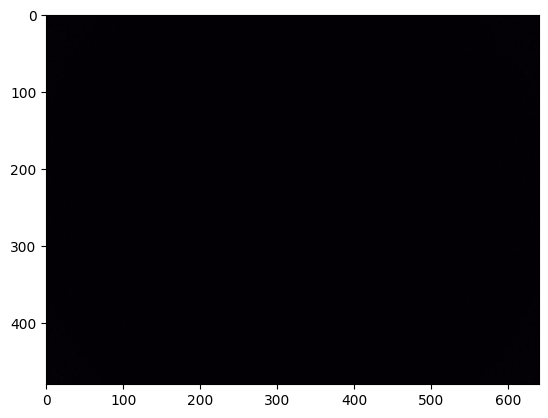

In [53]:
import cv2 as cv
from matplotlib import pyplot
from sign.training.landmark_extraction.MediaPiper import MediaPiper
from sign.landmarks import calc_landmark_list, pre_process_landmark
import numpy as np

mp = MediaPiper()
cap = cv.VideoCapture(0)


ret, frame = cap.read()

img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
img = cv.flip(img, 1)
res = mp.process_image(img)
print(res.multi_handedness)
if res.multi_handedness:
    print(f"Found handedness: {res.multi_handedness[0].label}")
try:
    if res.multi_hand_landmarks is not None:
        landmarks = calc_landmark_list(res.multi_hand_landmarks)

        # Conversion to relative coordinates / normalized coordinates
        landmarks = pre_process_landmark(landmarks)

        landmarks = np.array([landmarks], dtype=np.float32)    

       # scores = cls_left.decision_function(landmarks)
        #scores = (scores > 24)
        #candidates = [(klass, score) for score,klass in zip(*scores, cls_left.classes_) if score]
        #print(candidates)
        #probs = cls_left.predict_proba(landmarks)
        #print(probs)

        # CAN CHANGE THE MODEL HERE: 
        predictions = clf_u_l.predict(landmarks)
        # ^CAN CHANGE THE MODEL HERE
        print(predictions)
    else:
        print("there's nothing broski")
finally:
    pyplot.imshow(img)
    cap.release()
    cv.destroyAllWindows()